# Introduction

I had a need at work to understand the flow of a system. Knowing that a transition matrix would be perfect to understand state transitions, I researched available libraries within the Python ecosystem. Unfortunately, I could not find a suitable solution. 

My desires in a library included:
* It must capture states as strings or numbers for easy analysis.
* Store both frequencies and probabilities of state transitions.
* Allow simple filtering of frequencies and probabilities.
* Output the derived matrix as a panadas dataframe or numpy matrix.
* Plot the matrix as a Digraph.

This blog post shows my method of deriving a Markov transition matrix that covers all of those desires. This blog post **DOES NOT** discuss what a Markov transition matrix is in depth. You should read more about them on your own.

# Code

The code block below contains two important classes; Transition and TransitionMatrix. Transition is a class that keeps track of the current state and next state along with the frequency and probability. The TransitionMatrix stores all state transitions and provides methods for plotting and merging.

**Note**
The graphviz and pandas modules are required to run this code.

In [1]:
"""
This module is used to compute Markov Chains.
"""
import itertools
import copy

import pandas as pd

from graphviz import Digraph
from graphviz import Source

class Transition(object):
    """
    This class hold meta-data about a transition between a Markov stochastic process.
    Essentially it is used to keep track of frequencies and to compute probability of the
    transition.
    """
    def __init__(self, current_state, next_state):
        """
        Creates a transition object given the current_state and next_state as strings.
        

        Parameters
        ----------
        current_state : str
            The current state of this transition.
        next_state : str
            The next state of this transition.
        """
        self.current_state = current_state
        self.next_state = next_state
        self.prob = 0
        self.freq = 0
        
    def increment_freq(self):
        self.freq += 1
        
    def increment_freq_by(self, x):
        self.freq += x    
            
    def compute_prob(self, current_state_freqs):
        try:
            self.prob = self.freq / current_state_freqs
        except ZeroDivisionError:
            pass
    
    def __hash__(self):
        return hash((self.current_state, self.next_state))
    
    def __eq__(self, other):
        if not isinstance(other, Transition):
            return False
        
        return self.current_state == other.current_state \
            and self.next_state == other.next_state
        
    def __str__(self):
        return '{} -> {}'.format(self.current_state, self.next_state)
    
    def __copy__(self):
        tmp = Transition(self.current_state, self.next_state)
        tmp.increment_freq_by(self.freq)
        
        return tmp

class TransitionMatrix(object):
    """
    The transition matrix is an object that is used to derive the Stochastic matrix
    of a Markov chain. Internally, everything is storing in a dictionary of transitions.
    This class also provides methods to obtain dict of dict, pandas dataframe, dotlang or
    a graph representation of the matrix.
    """
    def __init__(self, states, valid_states=None):
        """
        This kicks off the computation of the matrix given states and optionally valid states.
        
        Parameters
        ----------
        states : :obj:`list` of :obj:`obj`
            The states to derive the matrix from. These states can be either int or str.
        valid_states : :obj:`list of :obj:`obj`, optional
            Optionally include valid states that are used to derive all valid transitions.
        """
        self.transitions = {}
        self.state_frequencies = {}
        
        if valid_states:
            self.__generate_transitions(valid_states)
        else:
            self.__generate_transitions(states)                
        
        self.__compute_matrix(states)
                
    def __generate_transitions(self, states):
        """
        Internal method that generates all permutations of transitions.
        """
        tmp = list(itertools.permutations(states, 2))

        current = None
        for t in tmp:
            if t[0] not in self.state_frequencies:
                self.state_frequencies[t[0]] = 0
            
            if current != t[0]:
                transition = Transition(t[0], t[0])
                self.transitions[transition] = transition
                current = t[0]

            transition = Transition(t[0], t[1])
            self.transitions[transition] = transition
            
    def __compute_matrix(self, states):
        """
        Internal method that computes frequencies and probability of the matrix.
        """
        for i, j in zip(states, states[1:]):        
            self.transitions[Transition(i, j)].increment_freq()
            self.state_frequencies[i] += 1
            
        self.__compute_prob()
            
    def __compute_prob(self):
        """
        Internal method that computes the probability of all transitions.
        """
        for transition in self.transitions:            
            self.transitions[transition].compute_prob(
                self.state_frequencies[self.transitions[transition].current_state]
            )
            
    def __recompute_from_transitions(self):
        """
        Internal method that is primarily used when filtering and/or combining transition
        matrices together. It is used to derive current state frequencies from transitions.
        This can then be used to compute the correct probabilities.
        """
        self.state_frequencies = {}
        for t in self.transitions:    
            c = self.transitions[t].current_state
            freq = self.transitions[t].freq
            
            if c not in self.state_frequencies:
                self.state_frequencies[c] = 0

            if freq > 0:
                self.state_frequencies[c] += freq
        
        self.__compute_prob()
            
    def as_dict(self, prob=False, include_all=False):
        """
        Converts the transition matrix into a dict of dicts.
        """
        tmp = {}
        for t in self.transitions:
            c = self.transitions[t].current_state
            n = self.transitions[t].next_state
            
            val = self.transitions[t].freq
            if prob:
                val = self.transitions[t].prob                        
            
            if val <= 0 and not include_all:
                continue
            
            if c not in tmp:
                tmp[c] = {}
                
            tmp[c][n] = val
        
        return tmp
    
    def as_dataframe(self, prob=False, include_all=False):
        return pd.DataFrame(self.as_dict(prob=prob, include_all=include_all))
    
    def as_dotlang(self):
        data = []
        for t in self.transitions:
            c = self.transitions[t].current_state
            n = self.transitions[t].next_state
            prob = self.transitions[t].prob
            
            if prob > 0:
                t = '   "{}" -> "{}" [label = "{:2.4f}"]'.format(c, n, prob)
                data.append(t)

        return "digraph G {\n%s\n}" % ('\n'.join(data))
    
    def as_graph(self):
        g = Digraph(format='svg', engine='dot')

        for t in self.transitions:
            c = self.transitions[t].current_state
            n = self.transitions[t].next_state
            prob = self.transitions[t].prob

            if prob > 0:
                g.edge(c, n, label=" {:2.4f} ".format(prob))                

        return g

# Example

In this example, I will generate a handful of states that occur linearly. The TransitionMatrix expects a list of values as the states or a string. If a string is passed, it treats each character in the string as a state.

In [2]:
import numpy as np

In [3]:
states_a = [np.random.choice(['A', 'B', 'C'], p=[0.2, 0.5, 0.3]) for i in range(1000)]

Passing the states into the matrix derives the frequencies and probabilities.

In [4]:
transition_matrix = TransitionMatrix(states_a)

## DataFrame

To obtain the matrix as a pandas dataframe we call the as_dataframe() method. By default we show the frequencies, however we can also get the probabilities.

In [5]:
transition_matrix.as_dataframe()

,A,B,C
A,41,102,49
B,88,262,155
C,62,142,98


In [6]:
transition_matrix.as_dataframe(prob=True)

,A,B,C
A,0.214660,0.201581,0.162252
B,0.460733,0.517787,0.513245
C,0.324607,0.280632,0.324503


## Visualize

We are able to visualize the transition matrix as a Digraph by calling the as_graph() method. If we wanted to export a dotfile, we can call the as_dotlang() method to obtain the dotlang string.

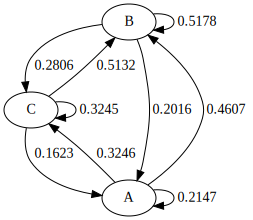

In [7]:
transition_matrix.as_graph()

## Filtering

Filtering is easily accomplished with a pandas dataframe.

In [8]:
df = transition_matrix.as_dataframe(prob=True)

In [9]:
df[df > 0.2]

,A,B,C
A,0.214660,0.201581,NaN
B,0.460733,0.517787,0.513245
C,0.324607,0.280632,0.324503


You can see that we filtered on a probability of 0.2 creating a NaN probability between C and A.